# Show, Attend and Tell - Implementation

 ## Import Libraries

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
import json
from torchvision import transforms
#from modules.model import *
from modules.custom_callbacks import *
from fastai.callbacks import lr_finder, SaveModelCallback, EarlyStoppingCallback,ReduceLROnPlateauCallback
#from fastai.callbacks.tensorboardX import *
from torch.nn.utils.rnn import pack_padded_sequence 
from torch.utils.data import Dataset, DataLoader
from fastai.vision import learner, data
from fastai.metrics import top_k_accuracy
from fastai.text import *
from fastai.vision import *
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
from sklearn.utils import shuffle
#import imageio
from PIL import Image

defaults.device = torch.device('cuda')
#CUDA_VISIBLE_DEVICES=""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#%load_ext tensorboard

## Image Databunch  Preparation

### Loading metadata

In [5]:
data_dir = '/home/cse/phd/anz198717/'

path = Path(f'{data_dir}/scratch/suchith_data/data/')
data_dump = Path('./data')

metadata = pd.read_csv(path/"Train_text.tsv", sep="\t",header=None)
metadata.rename(columns={0:'filename', 1:'labels'}, inplace=True)

In [6]:
metadata['filename'] = metadata.filename.apply(lambda x: f'{path}/{x}' )

In [7]:
metadata.head()

,filename,labels
0,/home/cse/phd/anz198717/scratch/suchith_data/d...,two men in green shirts
1,/home/cse/phd/anz198717/scratch/suchith_data/d...,a girl in an innertube
2,/home/cse/phd/anz198717/scratch/suchith_data/d...,several men in hard hats are
3,/home/cse/phd/anz198717/scratch/suchith_data/d...,a woman in a brown
4,/home/cse/phd/anz198717/scratch/suchith_data/d...,a little girl in a


### Processing captions text

In [8]:
captions = metadata['labels'].values

### Tokenization

In [9]:
tokenizer = Tokenizer()
tokens_captions = tokenizer.process_all(captions)

In [10]:
"""
with open(data_dump/'tokens_captions.pkl', 'wb') as file:
    pickle.dump(tokens_captions, file)
"""
pass

In [11]:
with open(data_dump/'tokens_captions.pkl', 'rb') as file:
    tokens_captions = pickle.load(file)

In [12]:
token_count = {}
for cap in tokens_captions:
    for t in cap:
        token_count[t] = token_count.get(t, 0) + 1

#### Looking at the captions

The captions are very skewed

In [13]:
v, c = zip(*token_count.items())
v = np.array(v)
c = np.array(c)
sort_pos = np.argsort(c)

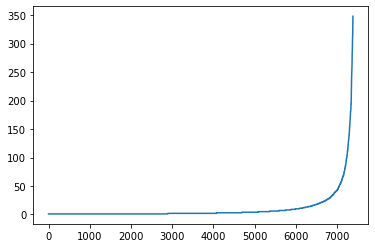

In [14]:
plt.plot(c[sort_pos][:-100])

In [15]:
v[sort_pos][-10:]

array(['with', 'and', 'on', 'two', 'the', 'woman', 'is', 'man', 'in', 'a'], dtype='<U16')

Average length of the captions

In [16]:
np.mean(list(map(len, tokens_captions)) )

5.82446

In [17]:
avg_pred = ['on', 'two', 'the', 'woman', 'is', 'man', 'in', 'a']
avg_senc = ' '.join(avg_pred)

saving the average predictions

In [18]:
test_dir = Path(path/'test_data')
test_files = list(map(lambda x: f'test_data/{x}', os.listdir(test_dir)))

In [19]:
pred = pd.DataFrame(test_files, columns=['filename'])
pred['labels'] = avg_senc

In [20]:
pred

,filename,labels
0,test_data/test4275.jpg,on two the woman is man in a
1,test_data/test1582.jpg,on two the woman is man in a
2,test_data/test4227.jpg,on two the woman is man in a
3,test_data/test1500.jpg,on two the woman is man in a
4,test_data/test3127.jpg,on two the woman is man in a
...,...,...
4995,test_data/test2690.jpg,on two the woman is man in a
4996,test_data/test4471.jpg,on two the woman is man in a
4997,test_data/test184.jpg,on two the woman is man in a
4998,test_data/test3606.jpg,on two the woman is man in a


In [21]:
pred.to_csv(path/'Test_text.tsv', sep="\t",header=None, index=None)

### Creating metadata dict

In [22]:
metadata['tokens'] = tokens_captions
_ = metadata['tokens'].apply(lambda x: x.append('<end>'))
_ = metadata['tokens'].apply(lambda x: x.insert(0, '<start>'))

In [23]:
vocab = Vocab.create(tokens_captions, max_vocab=50000, min_freq=2)

In [24]:
with open(data_dump/'vocab.pkl', 'wb') as file:
    pickle.dump(vocab, file)

In [25]:
metadata['numericalized'] = metadata.tokens.apply(lambda x: vocab.numericalize(x))

In [26]:
N = metadata.shape[0]
valid_pc = 0.2

num_valid = int(N*valid_pc)
rand_idx = np.random.permutation(N)
valid_idx = rand_idx[:num_valid]
train_idx = rand_idx[num_valid:]

In [27]:
metadata['split'] = 'train'
metadata['split'].iloc[valid_idx] = 'val'

In [28]:
metadata['SeqLen'] = metadata.numericalized.apply(len)

In [29]:
metadata.head()

,filename,labels,tokens,numericalized,split,SeqLen
0,/home/cse/phd/anz198717/scratch/suchith_data/d...,two men in green shirts,"[<start>, two, men, in, green, shirts, <end>]","[10, 17, 27, 12, 60, 191, 11]",train,7
1,/home/cse/phd/anz198717/scratch/suchith_data/d...,a girl in an innertube,"[<start>, a, girl, in, an, innertube, <end>]","[10, 9, 28, 12, 26, 0, 11]",val,7
2,/home/cse/phd/anz198717/scratch/suchith_data/d...,several men in hard hats are,"[<start>, several, men, in, hard, hats, are, <...","[10, 77, 27, 12, 238, 210, 22, 11]",train,8
3,/home/cse/phd/anz198717/scratch/suchith_data/d...,a woman in a brown,"[<start>, a, woman, in, a, brown, <end>]","[10, 9, 15, 12, 9, 50, 11]",train,7
4,/home/cse/phd/anz198717/scratch/suchith_data/d...,a little girl in a,"[<start>, a, little, girl, in, a, <end>]","[10, 9, 44, 28, 12, 9, 11]",train,7


In [30]:
metadata.shape

(50000, 6)

In [31]:
# split data in train and valid
"""
train_idx = metadata.index[metadata.split == 'train']
valid_idx = metadata.index[metadata.split == 'val']
"""
pass

In [32]:
# small batch of metadata for testing
"""
train_idx = train_idx[:100].to_list()
valid_idx = valid_idx[:100].to_list()
"""
pass

In [33]:
"""
metadata = metadata[metadata.index.isin(train_idx+valid_idx)]
metadata.reset_index(drop=True, inplace=True)
"""
pass

### Custom Datasets

In [34]:
# define Dataset object that outputs img path, caption, indices of reference captions 
class ImageCaptionDataset(Dataset):
    def __init__(self, data, split = 'train',transform=None):
        data = data[data.split == split]
        self.filenames = list(data['filename'])
        self.captions  = list(data['numericalized'])
        self.inds  = data.index.tolist()
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        # Grayscale images in dataset have to be onverted as tensor shapes have to match except in dim=0
        image = Image.open(self.filenames[idx]).convert('RGB')
        caption = self.captions[idx]
        ref_ind = self.inds[idx]

        
        if self.transform is not None:
            image = self.transform(image)
        
        return (image, caption, ref_ind)

In [35]:
# transformation resize img size to 350 px, tensoring, then normalize using image net stats
trans = transforms.Compose([
    transforms.Resize((350,350)),
    transforms.ToTensor()
    ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

inv_normalize = transforms.Normalize(
    mean=[-0.5238/0.3159, -0.5003/0.3091, -0.4718/0.3216],
    std=[1/0.3159, 1/0.3091, 1/0.3216]
)

denorm = transforms.Compose([
    inv_normalize,
    transforms.functional.to_pil_image
])

In [36]:
# create Dataset instense for both train set and valid
train_dataset = ImageCaptionDataset(metadata,'train',trans)
valid_dataset = ImageCaptionDataset(metadata,'val',trans)

<start> a woman drinks a beer <end>



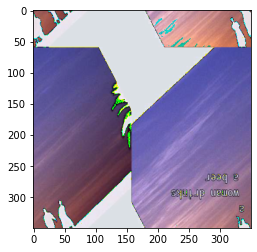

In [37]:
# check random sample
idx = 50
d = train_dataset
img, cap,ref = d[idx]

print(vocab.textify(cap)+'\n')

plt.imshow(denorm(img));

## Model Architecture

In [38]:
#%%writefile modules/models.py

# create a embedding layer
def create_emb(embedding_array):
    emb = nn.Embedding(len(word_map),embedding_dim)
    emb.weight.data = torch.from_numpy(embedding_array)
    return emb

class Encoder(nn.Module):
    def __init__(self,encode_img_size, fine_tune = False):
        super(Encoder, self).__init__()
        self.enc_imgsize = encode_img_size
        resnet = models.resnet101(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2]) # removing final Linear layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encode_img_size,encode_img_size))
        self.fine_tune = fine_tune
        self.fine_tune_h()
        
    def fine_tune_h(self):
        """
        Allow or prevent the computation of gradients for convolutional blocks 2 through 4 of the encoder.
        :param fine_tune: Allow?
        """
        for p in self.encoder.parameters():
            p.requires_grad = False
        
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.encoder.children())[5:]:
            for p in c.parameters():
                p.requires_grad = self.fine_tune
        
    def forward(self,X):
        out = self.encoder(X) # X is tensor of size (batch size, 3 (RGB), input height, width)
        out = self.adaptive_pool(out) # output (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)
        out = out.view(out.size(0), -1, out.size(3))
        return out
    
class Decoder(nn.Module):
    def __init__(self,attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5, pretrained_embedding = None,teacher_forcing_ratio = 0):
        super(Decoder, self).__init__()
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.encoder_dim = encoder_dim
        self.vocab_size = vocab_size
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size,embed_dim)
        self.lstm = nn.LSTM(decoder_dim + encoder_dim, decoder_dim,1, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # gate
        self.pretrained_embedding = pretrained_embedding
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.emb2dec_dim = nn.Linear(embed_dim, decoder_dim) # embed dim to decoder dim
        self.pretrained()
        
    def pretrained(self):
        if self.pretrained_embedding is not None:
            self.embedding.weight.data = torch.from_numpy(self.pretrained_embedding)
            
    def init_hidden_state(self, encoder_out):
        
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h.unsqueeze(0), c.unsqueeze(0)
            
    def forward(self,encoder_out, encoded_captions,decode_lengths,inds):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        num_pixels = encoder_out.size(1)
        embeddings = self.embedding(encoded_captions)
        
        ## initililize hidden encoding
        h, c = self.init_hidden_state(encoder_out)
        dec_out = torch.zeros(1,batch_size,decoder_dim).to(device)
        
        
        
        decode_lengths = decode_lengths - 1
        
        max_len = max(decode_lengths).item()
        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max_len, vocab_size)
        alphas = torch.zeros(batch_size, max_len, num_pixels)
        
        for t in range(max_len):
            batch_size_t = sum([l.item() > t for l in decode_lengths])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h.squeeze(0)[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h.squeeze(0)[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            # teacher forcing 
            use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
            emb_ff = self.emb2dec_dim(embeddings[:batch_size_t, t, :])
            inp_emb = emb_ff if (use_teacher_forcing or t==0) else dec_out.squeeze(0)[:batch_size_t]
            
            
            dec_out,(h, c) = self.lstm(
                torch.cat([inp_emb, attention_weighted_encoding], dim=1).unsqueeze(0),
                (h[:,:batch_size_t], c[:,:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(dec_out.squeeze(0)))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t,t , :] = preds
            alphas[:batch_size_t, t, :] = alpha
        return F.log_softmax(predictions, dim=1),decode_lengths, alphas, inds
        
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.enc_att = nn.Linear(encoder_dim,attention_dim)
        self.dec_att = nn.Linear(decoder_dim,attention_dim)
        self.att = nn.Linear(attention_dim,1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self,encoder_out, decoder_hidden):
        encoder_att = self.enc_att(encoder_out)
        decoder_att = self.dec_att(decoder_hidden)
        att = self.att(self.relu(encoder_att + decoder_att.unsqueeze(1))).squeeze(2) #testing added batchnorm 
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out*alpha.unsqueeze(2)).sum(dim=1)
        
        return attention_weighted_encoding, alpha
        

## DataLoaders  preparations

### Custom collate function

create a collate funtion with inputs bacth of imgs, caption pairs and sorts them by caption length in descending order

In [39]:

from functools import partial
def pad_collate_ImgCap(samples, pad_idx = 0, pad_first:bool=True, backwards:bool=False, transpose:bool=False, device = device):
    "Function that collect samples and adds padding. Flips token order if needed"
    images, captions, ref_ind = zip(*samples)
    max_len_cap = max([len(c) for c in captions])
    decode_lengths = torch.tensor([len(c) for c in captions])
    res_cap = torch.zeros(len(samples), max_len_cap).long() + pad_idx
    ref_ind = torch.tensor(ref_ind)
    
    if backwards: pad_first = not pad_first
    for i,c in enumerate(captions):
        if pad_first: 
            res_cap[i,-len(c):] = LongTensor(c)
        else:         
            res_cap[i,:len(c)] = LongTensor(c)
    
    if backwards:
        cap = cap.flip(1)
    if transpose:
        res_cap.transpose_(0,1)
    
    images = torch.stack(images, 0, out=None)
    
    # Sort input data by decreasing lengths; why? apparent below
    decode_lengths, sort_ind = decode_lengths.sort(dim=0, descending=True)
    #set_trace()
    
    images = images[sort_ind].to(device)
    res_cap = res_cap[sort_ind].to(device)
    ref_ind = ref_ind[sort_ind].to(device)
    decode_lengths = decode_lengths.to(device)
    
    
    return (images, res_cap, decode_lengths,ref_ind), res_cap[:, 1:]

In [40]:
imgcap_collate_func = partial(pad_collate_ImgCap, pad_idx=0, pad_first=False, transpose=False)

In [41]:
bs=4

### Create databunch with transformations

In [42]:
### train and validation dataloaders
train_sam = list(metadata.loc[metadata.split == 'train','numericalized'])
val_sam = list(metadata.loc[metadata.split == 'val','numericalized'])

### define Sampler for smapling bacthes for sorted pairs 
val_sampler = SortSampler(val_sam, key=lambda x: len(val_sam[x]))
trn_sampler = SortishSampler(train_sam, key=lambda x: len(train_sam[x]), bs=bs)

### define data loaders for loading inputs batches into network
val_dl = DataLoader(dataset=valid_dataset, batch_size=bs, sampler=val_sampler, collate_fn=imgcap_collate_func,pin_memory=False)
trn_dl = DataLoader(dataset=train_dataset, batch_size=bs, sampler=trn_sampler, collate_fn=imgcap_collate_func,pin_memory=False)


# transformations 
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

# fastai databunch object 
dataBunch = DataBunch(train_dl=trn_dl, valid_dl=val_dl ,device=device,collate_fn=imgcap_collate_func)

In [43]:
dataBunch.valid_ds[0]

(tensor([[[ 0.5878,  1.5125,  1.4612,  ...,  2.0605,  1.8379,  1.9064],
          [ 1.9920,  1.8208,  0.7248,  ...,  1.9235,  2.2147,  2.1633],
          [ 1.9578,  1.8722,  1.8550,  ...,  1.7694,  1.9064,  1.9578],
          ...,
          [-1.0390, -1.3987, -1.6042,  ..., -0.5424, -0.7137, -1.1418],
          [-1.0390, -0.8507, -0.7308,  ...,  0.1597, -0.6281,  0.3309],
          [ 0.9303, -0.3369, -0.6623,  ...,  2.1290,  1.7352,  1.6838]],
 
         [[ 0.5728,  1.5182,  1.4482,  ...,  2.2185,  1.9734,  2.0434],
          [ 2.0434,  1.8683,  0.7129,  ...,  2.0434,  2.3761,  2.3235],
          [ 2.0259,  1.9559,  1.9034,  ...,  1.8683,  2.0084,  2.0609],
          ...,
          [-0.8803, -1.3704, -1.6856,  ..., -0.6527, -0.8277, -1.2654],
          [-0.7752, -0.7402, -0.7927,  ...,  0.0651, -0.7402,  0.2402],
          [ 1.2381, -0.1975, -0.7227,  ...,  2.1310,  1.7283,  1.6758]],
 
         [[ 0.6879,  1.6465,  1.5594,  ...,  2.2217,  1.9777,  2.0125],
          [ 2.0997,  1.9254,

<start> the two man are dancing <end>


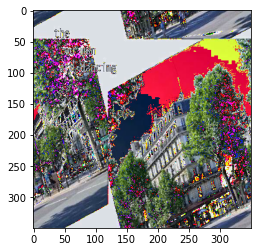

In [44]:
# visualize sample 
idx = 100
d = dataBunch.valid_ds
img, cap,_ = d[-1]

print(vocab.textify(cap))
plt.imshow(denorm(img));

## Model Intialization

### User inputs

Set Model configuartion 

In [45]:
import fasttext as ft

In [46]:
# ****************** USER INPUTS *****************
"""
data_folder = 'flicker8k-dataset/'
data_name = 'Vocab_5_cap_per_img_2_min_word_freq'
wordemb_pkl_path = 'flicker8k-dataset/Fastext_embedd_wordMap.pkl' # path to word embedding Fasttext: 'Fastext_embedd_wordMap.pkl'
"""
pass

In [47]:
en_vecs = ft.load_model(str(path/'models/wiki.en.bin'))
vec_dict = {w : en_vecs.get_word_vector(w) for w in en_vecs.get_words()}

In [48]:
embedding = np.stack(list(vec_dict.values()))

In [49]:
"""
with open(data_dump/'embeddings.pkl', 'wb') as file:
    pickle.dump(embedding, file)
"""
pass

In [50]:
with open(data_dump/'embeddings.pkl', 'rb') as file:
    embedding = pickle.load(file)

In [51]:
trainWithEmb = True
emb_dim = 300   # 300: pretrined words embedd GLove 
attention_dim = 512 # encoder_dim tranformed to attention_dim
decoder_dim = 512  #  word_emb_dim tranformed to decoder_dim
dropout = 0.5
encoder_dim = 2048 #512 for resnet34 and 2048 for resnet 101 
#cudnn.benchmark = True
vocab_size = len(vec_dict)
fine_tune_encoder = True
criterion = nn.CrossEntropyLoss().to(device)

# load word embeddings
#with open(wordemb_pkl_path,'rb') as f:
#    embedding = pickle.load(f)
#    embedding[4021:] = np.random.normal(embedding.mean(),embedding.std(),(4, 300))

## Model Architectures

### Model initialization

In [52]:
from modules.model import *
###########   Layer Initializations ##########
# testing initiation
enc = Encoder(14,fine_tune=False)
dec = Decoder(attention_dim, 
              emb_dim, 
              decoder_dim, 
              vocab_size, 
              encoder_dim=encoder_dim, 
              dropout=0.5, 
              pretrained_embedding = embedding,teacher_forcing_ratio=1)


# Models Ensemble 
class Ensemble(nn.Module):
    def __init__(self,encoder, decoder):
        super(Ensemble, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self,x1,caps,decode_lengths,inds): # you need flatten in between
        imgs = self.encoder(x1) # here input x1 is Images: output (batch_size, encoded_image_size, encoded_image_size, 2048)
        scores,decode_lengths,alphas, inds  = self.decoder(imgs, caps,decode_lengths,inds) #caps_sorted, decode_lengths, alphas, sort_ind
        return scores,decode_lengths, alphas, inds

# Testing
criterion = nn.CrossEntropyLoss().to(device)
enc = enc.to(device)
dec = dec.to(device)
arch = Ensemble(enc, dec).to(device)

In [53]:
def eval(img):
    encoder_out = self.model.encoder(img)

    num_pixels = encoder_out.size(1)
    encoder_out = encoder_out.expand(3, num_pixels, encoder_dim)


    # Tensor to store top k previous words at each step; now they're just 0
    k_prev_words = torch.LongTensor([[0]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)


    #dec_inp = torch.zeros(h.size(1), requires_grad=False).long()
    #dec_inp = dec_inp.to(self.device)

    complete_seqs = list()
    complete_seqs_scores = list()

    step = 1

    h,c = self.model.decoder.init_hidden_state(encoder_out)

    a = True
    while True:
        k_prev_words = torch.LongTensor([[0]] * 3).to(device)
        embeddings = self.model.decoder.embedding(k_prev_words).squeeze(1)
        awe, _ = self.model.decoder.attention(encoder_out, h)
        gate = self.model.decoder.sigmoid(self.model.decoder.f_beta(h))
        awe = gate * awe
        h, c = self.model.decoder.lstm(torch.cat([embeddings, awe], dim=1), (h, c))

        scores = self.model.decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)
        scores = top_k_scores.expand_as(scores) + scores
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)



        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)


        # If any sequence is not complete
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                                       next_word != pad_idx]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # if at step any of seq completes we store complete_seqs and proceeds with
        # remaining k - len(complete_seqs) incomplete seqs 

        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        if k == 0:
            break

        seqs = seqs[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]

        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

### Callback handler

Defining Callbacks

In [54]:
%%writefile custom_callbacks.py

class TeacherForcingCallback(Callback):
    def __init__(self, learn:Learner, decay_epochs=3):
        super().__init__()
        self.learn = learn
        self.decay_iterations = decay_epochs * len(self.learn.data.train_ds) // self.learn.data.batch_size
    
    def on_batch_begin(self, iteration,**kwargs):
        self.learn.model.decoder.teacher_forcing_ratio = (self.decay_iterations-iteration) * 1/self.decay_iterations if iteration < self.decay_iterations else 0
        
    def on_batch_end(self,**kwargs):
        self.learn.model.decoder.teacher_forcing_ratio = 0.

class GradientClipping(LearnerCallback):
    "Gradient clipping during training."
    def __init__(self, learn:Learner, clip:float = 0.3):
        super().__init__(learn)
        self.clip = clip

    def on_backward_end(self, **kwargs):
        "Clip the gradient before the optimizer step."
        if self.clip: nn.utils.clip_grad_norm_(self.learn.model.parameters(), self.clip)

        

class BleuMetric(Callback):
    def on_epoch_begin(self, **kwargs):
        self.references = list()
        self.candidates = list()
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        pred, decode_lengths,_,inds = last_output
        references = metadata.references[metadata.index.isin(inds.tolist())]
        _,pred_words = pred.max(dim=-1)
        vocab_i2s = dict(zip(vocab.values(),vocab.keys()))
        hypotheses = list()
        for cap in pred_words: hypotheses.append([vocab_i2s[x] for x in cap.tolist() if x not in 
                               {vocab['<start>'], vocab['<end>'], vocab['<pad>']}])
        self.references.extend(references)
        self.candidates.extend(hypotheses)

        
    def on_epoch_end(self, last_metrics, **kwargs):
        assert len(self.references) == len(self.candidates)
        return add_metrics(last_metrics, corpus_bleu(self.references, self.candidates, weights=(0.5,0.5,0.5,0.5)))

Overwriting custom_callbacks.py


### Learner create Object

In [55]:
#from modules.metrics import beam_search

opt_fn = partial(optim.Adam, betas=(0.8, 0.99))


# metrics functions
loss_func = partial(loss_func, lamb = 1)
#BleuMetric(metadata,vocab)
#beam_fn = partial(beam_search,beam_size = 5)

learn = Learner(dataBunch,arch,loss_func= loss_func,opt_func=opt_fn, metrics=[topK_accuracy,BleuMetric(metadata,vocab)],callback_fns=[ShowGraph]) #,TeacherForcingTurnOff,TeacherForcingCallback

# split model into encoder and decoder layer groups
split_list = [learn.model.encoder,learn.model.decoder]
learn.split(split_list)
len(learn.layer_groups)

2

In [56]:
def summary_trainable(learner):
    result = []
    total_params_element = 0
    def check_trainable(module):
        nonlocal total_params_element
        if len(list(module.children())) == 0:
            num_param = 0
            num_trainable_param = 0
            num_param_numel = 0
            for parameter in module.parameters():
                num_param += 1
                if parameter.requires_grad:
                    num_param_numel += parameter.numel()
                    total_params_element += parameter.numel()
                    num_trainable_param += 1

            result.append({'module': module, 'num_param': num_param , 'num_trainable_param' : num_trainable_param, 'num_param_numel': num_param_numel})
    learner.model.apply(check_trainable)

    print("{: <85} {: <17} {: <20} {: <40}".format('Module Name', 'Total Parameters', 'Trainable Parameters', '# Elements in Trainable Parametrs'))
    for row in result:
        print("{: <85} {: <17} {: <20} {: <40,}".format(row['module'].__str__(), row['num_param'], row['num_trainable_param'], row['num_param_numel']))
    print('Total number of parameters elements {:,}'.format(total_params_element))



# uncomment below to print summary of trainable layers 
#learn.freeze()
summary_trainable(learn)

Module Name                                                                           Total Parameters  Trainable Parameters # Elements in Trainable Parametrs       
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)          1                 0                    0                                       
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)       2                 0                    0                                       
ReLU(inplace=True)                                                                    0                 0                    0                                       
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)            0                 0                    0                                       
Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)                         1                 0                    0                                       
Batc

## Training

### Stage 1: with encoder part freezed

In [57]:
learn.freeze()
learn.lr_find(end_lr = 1)
learn.recorder.plot(suggestion=True)#;
#find_appropriate_lr(learn,plot=True)

epoch,train_loss,valid_loss,topK_accuracy,bleu_metric,time


RuntimeError: CUDA out of memory. Tried to allocate 4.81 GiB (GPU 0; 31.75 GiB total capacity; 24.23 GiB already allocated; 197.50 MiB free; 30.10 GiB reserved in total by PyTorch)

In [ ]:
# writer = SummaryWriter(comment='stage1')
# tb_callback = partial(TensorBoardFastAI, writer, 
#                       track_weight=True, track_grad=True, 
#                       metric_names=['val loss','accuracy','bleu_metric']) #beam_search_bleu4
                      
                      
#tb_callback(learn)


#TeacherForcingCallback(learn,decay_epochs=5),
#ReduceLROnPlateauCallback(learn, monitor='bleu_metric',patience=1,factor=0.1,min_lr=1e-10),

### train for 10 epochs
learn.freeze()
learn.fit(10,4e-4,callbacks = [SaveModelCallback(learn, monitor='bleu_metric',name='bestmodel_stage1'),
                                         GradientClipping(learn = learn, clip=5.)])
                                         #TeacherForcingCallback(learn)])
                    #,tb_callback(learn)])

### Stage-2: Unfreeze encoder part as well

In [ ]:
learn.data.batch_size = 6
learn.unfreeze()
learn.load('bestmodel_stage1');
learn.lr_find(start_lr=1e-11,end_lr = 1e-03)
learn.recorder.plot(suggestion=True)#;

#find_appropriate_lr(learn,plot=True)

In [ ]:
learn.data.batch_size = 6

# writer = SummaryWriter(comment='stage2')
# tb_callback = partial(TensorBoardFastAI, writer, 
#                       track_weight=True, track_grad=True, 
#                       metric_names=['val loss','accuracy','bleu_metric'])
                      
                      
#tb_callback(learn)


learn.unfreeze()
learn.load('bestmodel_stage1');
learn.fit_one_cycle(6,1e-4,
                    callbacks = [SaveModelCallback(learn, monitor='bleu_metric',name='bestmodel_stage2'),
                                 GradientClipping(learn = learn, clip=5.)])
#                                  TeacherForcingCallback(learn,decay_epochs=5000),
#                                  tb_callback(learn)])

In [ ]:
learn.save('last_epoch_stage2');

In [ ]:
!shutdown -h 10